In [211]:
#package
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using DataFrames
using CSV
using Base.Threads
using HDF5
gr()

Plots.GRBackend()

In [244]:
c = h5open("/Users/nishimura/home/lab/exmc/result/spc/spc1_B40.h5", "r") do file
    read(file, "B40")
end

1000×72 Matrix{Float64}:
  0.0162499    0.0593962    0.0278769   …  0.116708  0.11671   0.116714
  0.0159202    0.0591567    0.0282229      0.11672   0.11671   0.116714
  0.0594203    0.0277695    0.0378524      0.11671   0.116714  0.116705
  0.0597123    0.027875     0.0373814      0.116713  0.116714  0.116705
  0.0274397    0.0377798    0.0400221      0.116724  0.116705  0.116718
  0.0272238    0.0375807    0.0404072   …  0.116703  0.116705  0.116718
  0.0370909    0.0405801   -0.00918695     0.116718  0.116718  0.116704
  0.0370831    0.0407181   -0.00889055     0.11671   0.116718  0.116706
  0.0405547   -0.00850612   0.0297994      0.116718  0.116706  0.11671
  0.0410375   -0.00866317   0.0301265      0.116706  0.116713  0.11671
 -0.00882327   0.0304216    0.0574073   …  0.116713  0.11671   0.11671
 -0.00879398   0.0308102    0.0575231      0.116713  0.11671   0.116712
  0.0311323    0.0577453    0.0142001      0.116725  0.116712  0.116708
  ⋮                                     ⋱ 

In [245]:
ac = h5open("/Users/nishimura/home/lab/exmc/result/spc/spc1_ac_ex.h5", "r") do file
    read(file, "ac")
end

ex = h5open("/Users/nishimura/home/lab/exmc/result/spc/spc1_ac_ex.h5", "r") do file
    read(file, "ac")
end

72-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.999
 0.999
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.37
 0.375
 0.433
 0.413
 0.414
 0.482
 0.456
 0.451
 0.497
 0.513
 0.505
 0.52

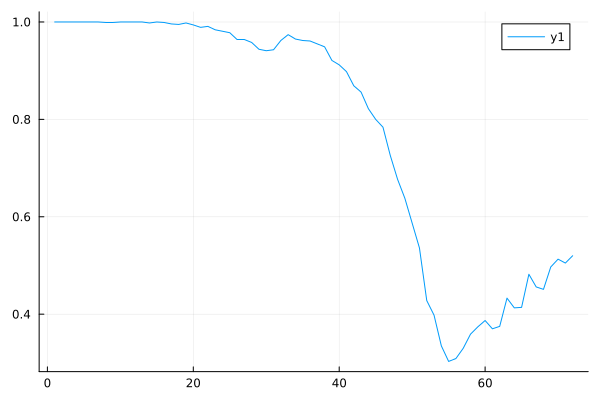

In [246]:
plot(ac)

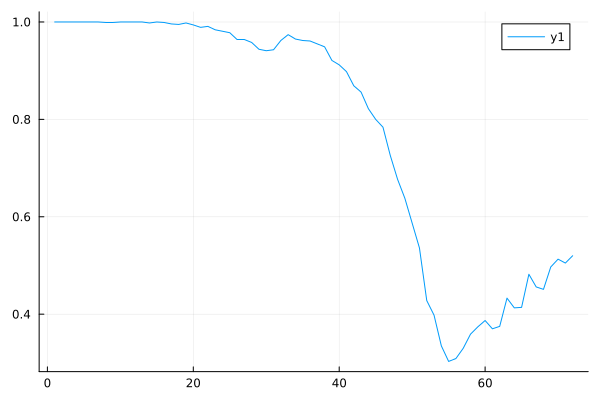

In [247]:
plot(ex)

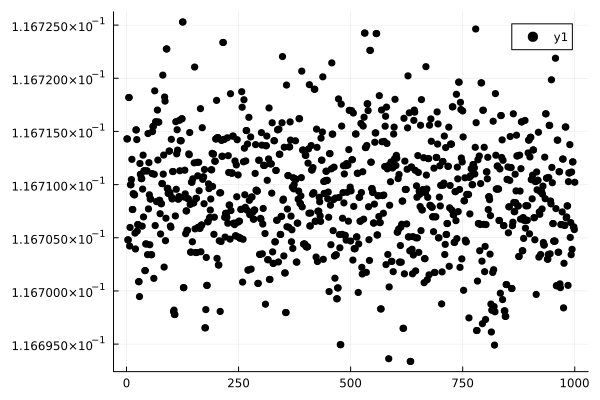

In [248]:
plot(
    c[:,end],
    st = :scatter,
    color = :black,
)

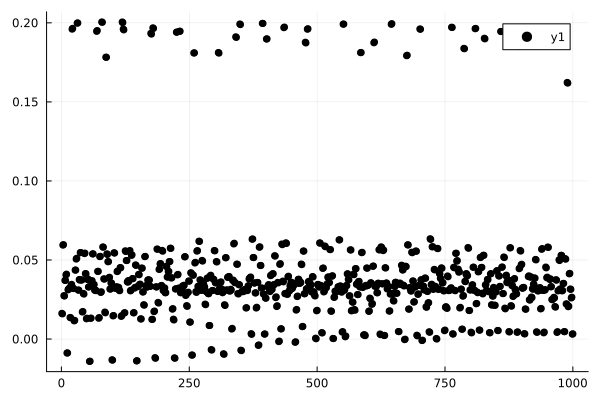

In [249]:
plot(
    c[:,1],
    st = :scatter,
    color = :black,
)

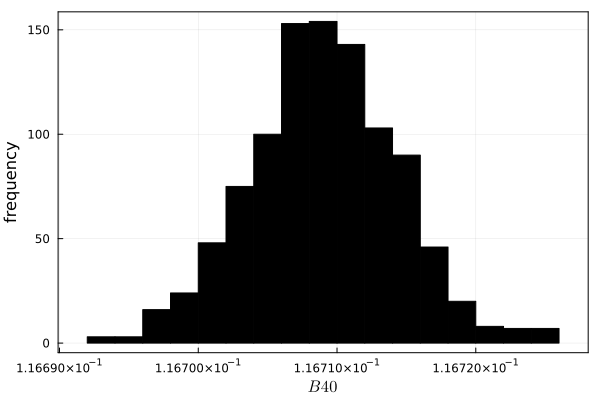

In [250]:
plot(
    c[:,end],
    st = :histogram,
    color = :black,
    label = "",
    framestyle = :box,
    xlabel = L"B40",
    ylabel = "frequency",
)

In [251]:
savefig("/Users/nishimura/home/lab/exmc/posterior/spc/spc1.pdf")

"/Users/nishimura/home/lab/exmc/posterior/spc/spc1.pdf"

In [252]:
# 本データ読み込み
function read_file_spc(file_path)
    file = h5open(file_path, "r")
    data = read(file, "spc")
    return data
end

read_file_spc (generic function with 1 method)

In [253]:
#データ数
function data_num_spc()
    n_spc = 350
    return n_spc
end
n_spc = data_num_spc()

#各種結晶場パラメータ
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1.0
    L = 3.0
    S = 0.5
    J = L - S
    g = 1.0 + (J * (J + 1.0) + S * (S + 1.0) - L * (L + 1.0)) / (2.0 * J * (J + 1.0))
    Jz = [2.5, 1.5, 0.5, -0.5, -1.5, -2.5]
    return J, g, Jz
end

#温度配列
function temp()
    Temp_table_spc = collect(0.2:0.2:70) # length 350
    return Temp_table_spc
end

#結晶場行列
function Onn_make(B40)
    # O40
    O40_vec_x = [60.0, -180.0, 120.0, 120.0, -180.0, 60.0]
    O40_vec = O40_vec_x * B40
    O40 = diagm(0 => O40_vec)
    Onn = O40
    # O44
    B44 = 5 * B40
    O44_value = sqrt(120.0 * 24.0) * B44 / 2.0
    Onn[5,1] = O44_value
    Onn[6,2] = O44_value
    Onn[1,5] = O44_value
    Onn[2,6] = O44_value
    return Onn
end

function spc(Onn)
    #パラメータ読み込み
    _, g, _ = ini()

    # 非対角要素
    Hmag_vec_1 = sqrt.([5,8,9,8,5]) * (1 + 1*im) * 5 * g * 0.67171 / 2
    Hmag_1 = diagm(1 => Hmag_vec_1)
    Hmag_2 = diagm(-1 => conj.(Hmag_vec_1))
    Hmag = Hmag_1 + Hmag_2

    #結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    Temp_table_spc = temp()
    SpcHeat_Temp = zeros(length(Temp_table_spc))
    
    @inbounds for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

function error_spc(B40, SpcHeat_Temp_noise)
    error_value = sum((SpcHeat_Temp_noise - spc(Onn_make(B40))).^2)/(2*n_spc)
    return error_value
end

function error_spc_list(para_list, SpcHeat_Temp_noise)
    error_list = zeros(size(para_list)[1],size(para_list)[2])
    @threads for i in 1:size(para_list)[1]
        for j in 1:size(para_list)[2]
            error_list[i,j] = error_spc(para_list[i,j], SpcHeat_Temp_noise)
        end
    end
    return error_list
end

error_spc_list (generic function with 1 method)

In [254]:
function make_beta(gamma,L)
    #最初は等差で決定
    beta_list = gamma.^( (2:1:L) .- (L) )
    beta_list = pushfirst!(beta_list, 0.0)
    return beta_list
end

make_beta (generic function with 1 method)

In [255]:
function find_free_energy_spc(error, b_spc, gamma, L)
    # 温度リスト
    beta = make_beta(gamma, L)
    #温度差
    beta_dif = beta[2:end] - beta[1:end-1]
    
    #温度差をかける
    for replica in 1:L-1
        error[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error *= - n_spc * b_spc
    
    #最大値取得
    error_max = zeros(L-1)
    for replica in 1:L-1
        error_max[replica] = maximum(error[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_dif = copy(error)
    for replica in 1:L-1
        error_dif[:,replica] = error[:,replica] .- error_max[replica]
    end
    
    #期待値計算
    log_exp_sum = zeros(L-1)
    for replica in 1:L-1
        log_exp_sum[replica] = log(sum(exp.(error_dif)[:,replica]))
    end
    
    #各レプリカでの自由エネルギー期待値
    free_energy_for_replica = -(- log(size(error)[1]) .+  error_max .+ log_exp_sum)
    
    #最終的な自由エネルギー(足し算)
    free_energy = sum(free_energy_for_replica) - n_spc/2*(log(b_spc)-log(2*pi))
    
    return free_energy
end

find_free_energy_spc (generic function with 1 method)

In [256]:
function main(para, data_path, save_path)
    #para = read_para(para_path)
    SpcHeat_Temp_noise = read_file_spc(data_path)

    b_spc = 10^(5)
    error_list = error_spc_list(para, SpcHeat_Temp_noise)

    #レプリカ数
    L = 72
    #逆温度間隔決定
    gamma = 1.4
    # 自由エネルギー
    free_energy = find_free_energy_spc(error_list, b_spc, gamma, L)

    # データフレームに書き出し
    #df_error = DataFrame(error_list, :auto)
    #df_error |> CSV.write(save_path * "error.csv",writeheader=true)

    #free_path = save_path * "free.h5"
    #=
    h5open(free_path, "w") do file
        write(file,"free",free_energy)
    end
    =#

    print("free_energy=", free_energy)
end

main (generic function with 1 method)

In [257]:
data_path = "/Users/nishimura/home/lab/data_make/data/spc/spc_1.h5"

#para_path = "/Users/test/home/lab_research_1/exmc/result/spc/spc1_B40.csv"

#save_path = "/Users/nishimura/home/lab/exmc/free_energy_check/spc/spc5_"
save_path = ""

main(c, data_path, save_path)

free_energy=-1488.5031728983358